# Поиск клиентов с неоптимальным тарифом

 **Описание проекта**:
 
     Клиенты провайдера "Телеком"  − колл-центры, необходимо проанализировать тарифы, чтобы узнать насколько они подходят клиентам и на основе этого дать возможные рекомендации по смене тарифов с целью предоставления      наивыгоднейших тарифов по сравнению с конкурентами.
    

 **Описание данных**  

**Датасет /datasets/telecom_dataset.csv:**    


user_id — идентификатор клиента;  
date — дата статистики;  
direction — направление вызовов: out — исходящий вызов, in — входящий;  
internal — маркер внутренних и внешних вызовов;  
operator_id — идентификатор оператора;  
is_missed_call — маркер пропущенных вызовов;  
calls_count — количество звонков;  
call_duration — длительность звонка без учёта времени ожидания;  
total_call_duration — длительность звонка с учётом времени ожидания.  

**Датасет /datasets/telecom_clients.csv:**  


user_id — идентификатор клиента;  
tariff_plan — тарифный план клиента;  
date_start — дата регистрации клиента в сервисе.  

**Цель исслдования:**

Найти клиентов, которые:   
а) переплачивают на текущих тарифах;   
б) сэкономят, если перейдут на более дорогой тариф.  
    
    

## Подготовка и анализ данных

### Импорт и проверка качества данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import scipy

In [2]:
calls_raw = pd.read_csv('/datasets/telecom_dataset.csv')
clients_raw = pd.read_csv('/datasets/telecom_clients.csv')

In [3]:
calls_raw.head() # посмотрим с какими данными нам придется работать 

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [4]:
calls_raw.info() #исследуем какой тип данных в каждом столбце

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


Датасет имеет 53902 записи:
- `operator_id` имеет пропуски
- `internal` имеет пропуски    

Необходимо поменять тип данных:
- `date`  - дата имеет тип `object`, необходимо поменять на `datetime`
- `internal` - имеет тип `object`, необходимо привести к булевому значению (`bool`)
- `operator_id` - имеет тип `float`, необходимо привести к `int64` 

Наименование столбцов приведены к нижнему регистру, пробелов в наименований нет(используется "змеиный_регистр")

In [5]:
clients_raw.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [6]:
clients_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


Датасет имеет 732 записи:
- пропусков в сете нет

Необходимо поменять тип данных:
- `date_start`  - дата имеет тип `object`, необходимо поменять на `datetime`

Наименование столбцов приведены к нижнему регистру, пробелов в наименований нет(используется "змеиный_регистр")

### Предобработка данных

#### Преобразование столбцов к удобному типу данных

In [7]:
calls = calls_raw.copy()
clients = clients_raw.copy()

In [8]:
#Ранее были определены столбцы по которым необходимо провести корректировку
calls['date'] = pd.to_datetime(calls['date']).dt.date.astype('datetime64[ns]')
calls['internal'] = calls['internal'].astype('boolean')
calls['operator_id'] = calls['operator_id'].astype('Int64')

clients['date_start'] = pd.to_datetime(clients['date_start'])

#### Проверим данные на наличие дубликатов

In [9]:
calls.duplicated().sum()

4900

В датасете 4900 дубликатов, но тяжело судить в количественном размере, много это или мало от всех значений, поэтому найдет процент от общего числа.

In [10]:

print(round(calls.duplicated().mean()*100, 2), '% дубликатов от общего числа')

9.09 % дубликатов от общего числа


ВВиду наличия явных дубликатов, которые могу привести к погрешности при дальнейшем исследовании, необходимо исключить их.

In [11]:
calls = calls.drop_duplicates().reset_index(drop=True)
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49002 entries, 0 to 49001
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              49002 non-null  int64         
 1   date                 49002 non-null  datetime64[ns]
 2   direction            49002 non-null  object        
 3   internal             48892 non-null  boolean       
 4   operator_id          41546 non-null  Int64         
 5   is_missed_call       49002 non-null  bool          
 6   calls_count          49002 non-null  int64         
 7   call_duration        49002 non-null  int64         
 8   total_call_duration  49002 non-null  int64         
dtypes: Int64(1), bool(1), boolean(1), datetime64[ns](1), int64(4), object(1)
memory usage: 2.8+ MB


In [12]:
clients.duplicated().sum()

0

Дубликатов в датасете с клиентами нет.

In [13]:
# ячейка ревьюера: подгрузим данные
tmp = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_dataset.csv')

# посмотрим на особенности данных, содержащие дубликаты:
(tmp[tmp.duplicated() == True] # оставляем только дубликаты
 .groupby(['is_missed_call','direction','internal']) # группируем по важным признакам
 .agg({'user_id':'nunique','calls_count':'sum','total_call_duration':'sum'}) # подсчитываем ключевые метрики
 .assign(calls_share = lambda x: x['calls_count'] / tmp[tmp.duplicated() == True].calls_count.sum()) # смотрим на доли
)

user_id  calls_count  total_call_duration  \
is_missed_call direction internal                                              
False          in        False         200         9831              1147031   
                         True           14           41                 2577   
               out       False         162        33110              3731852   
                         True           34          672                50826   
True           in        False         209         9060               103820   
                         True           21           77                 1318   
               out       False         148        26803               656727   
                         True           60          443                 3598   

                                   calls_share  
is_missed_call direction internal               
False          in        False        0.122817  
                         True         0.000512  
               out       False        0.413637  
                         True         0.008395  
True           in        False        0.113185  
                         True         0.000962  
               out       False        0.334845  
                         True         0.005534

In [14]:
# ячейка ревьюера

# посмотрим на особенности данных, если удалим дубликаты:
(tmp[tmp.duplicated() != True]
 .groupby(['is_missed_call','direction','internal'])
 .agg({'user_id':'nunique','calls_count':'sum','total_call_duration':'sum'})
 .assign(calls_share = lambda x: x['calls_count'] / tmp[tmp.duplicated() != True].calls_count.sum())
)

user_id  calls_count  total_call_duration  \
is_missed_call direction internal                                              
False          in        False         273        92786             10975841   
                         True           47          677                58125   
               out       False         209       329306             37470202   
                         True           83         7963               591475   
True           in        False         303       103219              1280794   
                         True           76          944                19315   
               out       False         214       266518              6223935   
                         True          140         5071                44990   

                                   calls_share  
is_missed_call direction internal               
False          in        False        0.115018  
                         True         0.000839  
               out       False        0.408209  
                         True         0.009871  
True           in        False        0.127951  
                         True         0.001170  
               out       False        0.330377  
                         True         0.006286

#### Проверим на отрицательные значения в данных

In [15]:
calls.min()

user_id                             166377
date                   2019-08-02 00:00:00
direction                               in
internal                             False
operator_id                         879896
is_missed_call                       False
calls_count                              1
call_duration                            0
total_call_duration                      0
dtype: object

In [16]:
clients.min()

user_id                     166373
tariff_plan                      A
date_start     2019-08-01 00:00:00
dtype: object

Как видим, в минимальное значение по каждому столбцу показывает отсутствие отрицательных значение

#### Проверка на наличие пустых ячеек

Определим в процентном соотношении количество пропусков 

In [17]:
round(100 * calls_raw[['internal', 'operator_id']].isna().mean(), 2)

internal        0.22
operator_id    15.16
dtype: float64

Ввиду необходимости провести расчет затрат клиентов не целесообразно заполнять пропуски какими-либо значением. Приводить к среднему или медианному значению тоже приведет к погрешности при дальнейшем анализе. Оставим без изменений

In [18]:
# ячейка ревьюера:
tmp = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_dataset.csv')

(tmp
 .query('operator_id != operator_id') # оставляем только пропуски
 .groupby(['is_missed_call','direction']) # группируем по важным признакам
 .agg({'user_id':'nunique','calls_count':'sum'})  # подсчитываем какие-то метрики
 .assign(calls_share = lambda x: x['calls_count'] / tmp.query('operator_id != operator_id').calls_count.sum(),
         total_calls_share = lambda x: x['calls_count'] / tmp.calls_count.sum()) # добавляем новый столбец с расчетом долей 
)

user_id  calls_count  calls_share  total_calls_share
is_missed_call direction                                                      
False          in              10          714     0.006279           0.000805
               out              3          334     0.002937           0.000377
True           in             305       112453     0.988893           0.126814
               out             49          215     0.001891           0.000242

#### Рассматриваемый период

In [19]:
#clients.info()
print(clients['date_start'].min())
print(clients['date_start'].max())

2019-08-01 00:00:00
2019-10-31 00:00:00


In [20]:
#calls.info()
print(calls['date'].min())
print(calls['date'].max())

2019-08-02 00:00:00
2019-11-28 00:00:00


Как видим, представленные датасеты происходят в один и тот же период.

В исследовании предоставлены данные за период с 01.08.2019 по 28.11.2019.

Клиенты начали регистрироваться с 01.08.2019 по 31.10.2023.

#### Проверим, что общая длительность звонков должна быть меньше чем общее время с учетом ожидания

In [21]:
calls[calls['total_call_duration'] < calls['call_duration']]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration


Как видим, данное условие выполняется

#### Проверим на аномалию, согласования даты регистрации и первого звонка клиента

Для проверки данной анномалии, необходимо объеденить данные датасеты

In [22]:
data = calls.merge(clients, on='user_id', how='left')

In [121]:
data.to_csv('data.csv', index=False) 

In [122]:
display(data)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration_sec,total_call_duration_sec,tariff_plan,date_start,call_duration_min,total_call_duration_min,month,month_name,waiting_time,avg_wait_time_per_call,day,weekday
0,166377,2019-08-04,in,False,<NA>,True,2,0,4,B,2019-08-01,0.000000,0.066667,8,August,0.066667,0.033333,4,Sunday
1,166377,2019-08-05,out,True,880022,True,3,0,5,B,2019-08-01,0.000000,0.083333,8,August,0.083333,0.027778,5,Monday
2,166377,2019-08-05,out,True,880020,True,1,0,1,B,2019-08-01,0.000000,0.016667,8,August,0.016667,0.016667,5,Monday
3,166377,2019-08-05,out,True,880020,False,1,10,18,B,2019-08-01,0.166667,0.300000,8,August,0.133333,0.133333,5,Monday
4,166377,2019-08-05,out,False,880022,True,3,0,25,B,2019-08-01,0.000000,0.416667,8,August,0.416667,0.138889,5,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48277,168606,2019-11-10,out,True,957922,False,1,0,25,C,2019-10-31,0.000000,0.416667,11,November,0.416667,0.416667,10,Sunday
48278,168606,2019-11-10,out,True,957922,True,1,0,38,C,2019-10-31,0.000000,0.633333,11,November,0.633333,0.633333,10,Sunday
48279,168606,2019-11-11,out,True,957922,False,2,479,501,C,2019-10-31,7.983333,8.350000,11,November,0.366667,0.183333,11,Monday
48280,168606,2019-11-15,out,True,957922,False,4,3130,3190,C,2019-10-31,52.166667,53.166667,11,November,1.000000,0.250000,15,Friday


In [23]:
# Определяем дельту между датой регистрации и первого звонка
dates_check_df = (data.groupby(['user_id', 'date_start'], as_index=False)['date']
                                  .min().assign(date_diff=lambda x: x['date']-x['date_start']))

# Выводим минимальную дельту
dates_check_df['date_diff'].min() 

Timedelta('0 days 00:00:00')

Минимальная дельта не отрицательная, значит аномалий нет.

Рассмотрим более детально, какие значения у нас представлены, как они разбросаны для определение размерности времени.

In [24]:
data['call_duration'].describe() 

count     49002.000000
mean        866.282091
std        3775.503352
min           0.000000
25%           0.000000
50%          37.000000
75%         570.000000
max      144395.000000
Name: call_duration, dtype: float64

Стоит обратить внимание, что медианное значение 866 едениц:

предположим что данное значение в секундах, соответственно медианное значение длительности одного разговора в минутах составляет 14.4 минуты
предположим что данное значение в минутах, соответвенно медианное значение одного разговора 36 часов. Уже заставляет задуматься, что больше половины значений находятся выше 24 часов(что просто уже не логично, поскольку в сутках 24 часа).
Исходя из выводов сделанных в п.2 принимаем значение указанные в стобце call_duration в секундах

Тогда:

Среднее значение длительности всех разговоров составляет 866 сек или 14.4 минуты
75% всех значений длительности разговоров не превышает 570 сек или 9.5 минут
Поэтому переведём все значения длительности (принимая что в секундах) в минуты.



Рассчитаем длительность звонков в минутах и проверим, что для одного оператора суммарная дневная длительность не превышает 24*60=1440 минут.

Создадим дополнительные столбцы куда запишем время в минутах.

In [25]:
data['call_duration_min'] = data['call_duration'] / 60
data['total_call_duration_min'] = data['total_call_duration'] / 60

data.rename(columns={'call_duration': 'call_duration_sec', 
                     'total_call_duration': 'total_call_duration_sec'},
           inplace=True)

In [26]:
operator_calls_duration = (data.groupby(['operator_id', 'date'], as_index=False)
                               .agg({'call_duration_min': 'sum','total_call_duration_min': 'sum'}))

operator_calls_duration

,operator_id,date,call_duration_min,total_call_duration_min
0,879896,2019-08-02,0.516667,4.750000
1,879896,2019-08-03,0.900000,5.283333
2,879896,2019-08-04,1.900000,2.333333
3,879896,2019-08-05,31.816667,35.950000
4,879896,2019-08-06,86.000000,95.950000
...,...,...,...,...
19642,972412,2019-11-28,32.133333,40.183333
19643,972460,2019-11-27,2.150000,4.850000
19644,972460,2019-11-28,18.150000,25.783333
19645,973120,2019-11-27,0.083333,0.416667


После объединения, имеем общую длительность разговоров для операторов.

In [27]:
operator_calls_duration.query('call_duration_min > 1440')

,operator_id,date,call_duration_min,total_call_duration_min
824,885876,2019-09-02,1524.116667,2106.933333
825,885876,2019-09-03,1478.500000,2212.616667
826,885876,2019-09-04,1567.583333,2112.050000
827,885876,2019-09-05,1855.116667,2260.583333
828,885876,2019-09-06,1492.316667,1914.683333
831,885876,2019-09-09,2042.016667,2680.433333
833,885876,2019-09-11,1928.366667,2490.233333
834,885876,2019-09-12,2111.933333,2563.216667
835,885876,2019-09-13,1664.883333,2124.700000
839,885876,2019-09-17,1686.050000,2508.100000


Есть оператор, у которого длительность звонков за день превышает 24 часа. Посмотрим подробнее на данные по этому оператору.

In [28]:
# Посмотрим более внимательно на данного оператора
operator_stat = (data.query('operator_id == 885876')
                         .groupby('date', as_index=False)['call_duration_min'].sum())

operator_stat['call_duration_min'].describe()

count      97.000000
mean      749.820103
std       706.120874
min         0.000000
25%        99.500000
50%       521.283333
75%      1353.950000
max      2416.766667
Name: call_duration_min, dtype: float64

Для этого оператора нашлось 97 записей, в среднем он разговаривает 749 минут в день (медианное время 521, значительно ниже среднего). Максимальная дневная длительность звонка составила 2416 минут - это 40 с лишним часов.

Выведем график зависимоти длительности звонков этого оператора от даты:

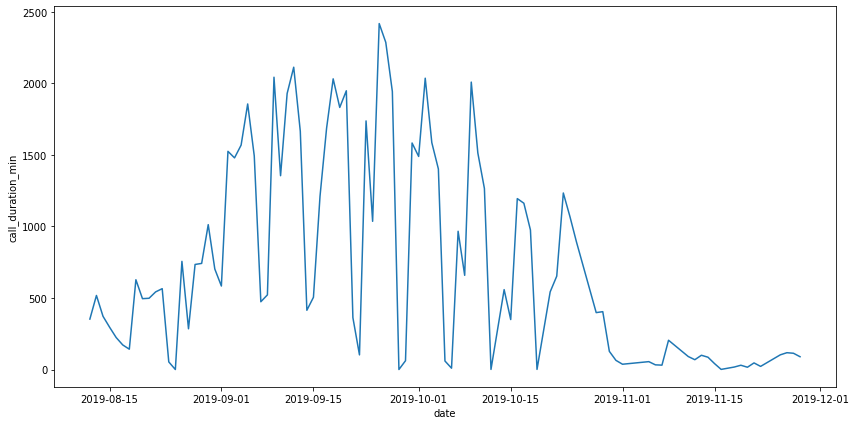

In [29]:
fig, ax = plt.subplots(figsize=(14,7))

sns.lineplot(data=operator_stat, 
             x='date', 
             y='call_duration_min',
             ax=ax);

Найдем клиента, у которого работает этот оператор и проверим остальных его операторов

In [30]:
data.query('operator_id == 885876')['user_id'].unique()

array([166582])

In [31]:
anomaly_user_stat = (
    data.query('user_id == 166582')
    .groupby(['date', 'operator_id'], 
             as_index=False)['call_duration_min']
    .sum()
)
anomaly_user_stat['operator_id'] = anomaly_user_stat['operator_id'].astype(str)

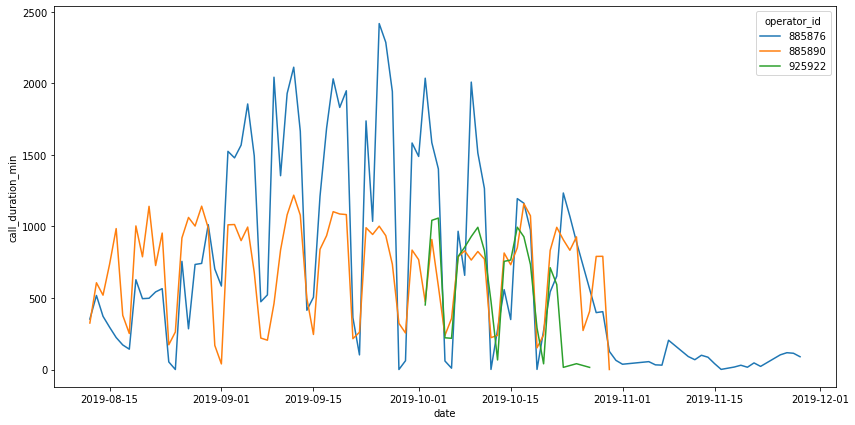

In [32]:
fig, ax = plt.subplots(figsize=(14,7))
sns.lineplot(data=anomaly_user_stat, 
             x='date', 
             y='call_duration_min', 
             hue='operator_id',
             ax=ax);

Кажется, что по остальным операторам такой проблемы нет, их звонки выглядят равномерными и не превышают разумных значений. Видимо, искажены только данные по оператору 885876 и только за сентябрь-октябрь. Возможно, произошел какой-то технический сбой и под одной учеткой работали несколько операторов.

Мы не можем удалить только этого оператора для клиента, т.к. это исказит расчет стоимости связи. Поэтому из анализа придется исключить самого клиента.

In [33]:
data = data.query('user_id != 166582')
data.reset_index(drop=True, inplace=True)
data.shape

(48282, 13)

**ДОПОЛНИТЕЛЬНАЯ ПРОВЕРКА**

Посмотрим как распределение выглядит сейчас

In [34]:
print(data[['calls_count', 'call_duration_sec',  'total_call_duration_min']].describe())

        calls_count  call_duration_sec  total_call_duration_min
count  48282.000000       48282.000000             48282.000000
mean      13.715443         702.457023                15.477809
std       50.312615        1780.051094                34.724086
min        1.000000           0.000000                 0.000000
25%        1.000000           0.000000                 0.766667
50%        4.000000          37.000000                 3.366667
75%       12.000000         560.000000                14.383333
max     4817.000000       41344.000000               967.116667


Напомню, что одной из задач будет определить траты клиентов по месяцам за связь, стоит выделить месяц в отдельный столбец. К тому же, стоит отметить, что рассматриваемый период находится в одном календарном году, не будет путаницы в части определения даты.

In [35]:
data['month'] = data['date'].dt.month
data['month_name'] = data['date'].dt.month_name()

In [36]:
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration_sec,total_call_duration_sec,tariff_plan,date_start,call_duration_min,total_call_duration_min,month,month_name
0,166377,2019-08-04,in,False,<NA>,True,2,0,4,B,2019-08-01,0.000000,0.066667,8,August
1,166377,2019-08-05,out,True,880022,True,3,0,5,B,2019-08-01,0.000000,0.083333,8,August
2,166377,2019-08-05,out,True,880020,True,1,0,1,B,2019-08-01,0.000000,0.016667,8,August
3,166377,2019-08-05,out,True,880020,False,1,10,18,B,2019-08-01,0.166667,0.300000,8,August
4,166377,2019-08-05,out,False,880022,True,3,0,25,B,2019-08-01,0.000000,0.416667,8,August


### Вывод
Проведенная подготовка данных показала, что в дата сете имеются "шумы" (пропуски, дубли, аномалии и т.п.), в последствии они были устарнены. Также дополнительно были добавлены вспомогательные столбцы, для дальнейшего анализа.



Данные о звонках имеют достаточно широкое распределение значений. Средние показатели существенно смещены от медианных, что говорит о различии структурных и количественных характеристик, в следствии наличия выбросов. Длительность вызовов достаточно широко варьируется. Есть аномальные значения, например, длительность вызовов более 24 часов. Поскольку исходящие вызовы тарифицируются, такие данные некорректны. Клиента с такими аномалиями целесообразно подвергнуть более тщательному анализу с более широким спектром данных.

## Исследовательский анализ данных

### Анализ количества клиентов

#### По тарифам

Опеределим количество клиентов на каждом тарифе

In [37]:
tariffs_stat = data.groupby('tariff_plan', as_index=False)['user_id'].nunique()
tariffs_stat

,tariff_plan,user_id
0,A,33
1,B,112
2,C,161


Ввиду дальнейшего постоянного построения графиков в виде баров, создадим функцию

In [38]:
def create_barchart(df, x, y, xlabel, ylabel, title, figsize=(14, 6)): 
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(data=df, x=x, y=y, ax=ax)
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show();

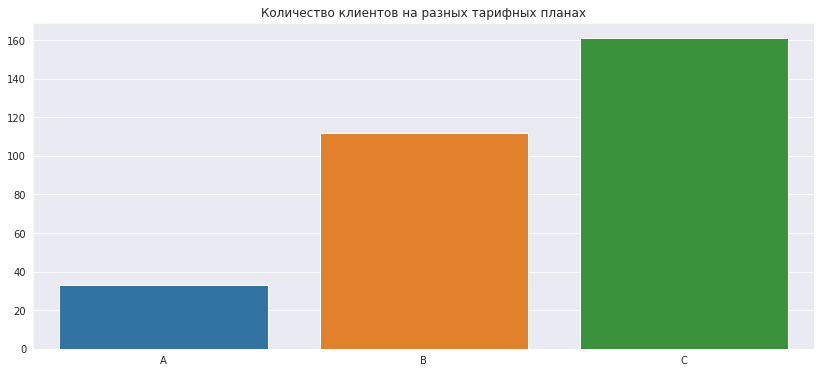

In [39]:
create_barchart(tariffs_stat, x='tariff_plan', y='user_id', xlabel='', 
                    ylabel='', title='Количество клиентов на разных тарифных планах')


Из полученных данных имеем:

наиболее популярный тариф у клиентов "тариф С", самый дешевый тариф
втром вариантом клиенты выбирают "тариф В"
самым не популярынм тарифом для клиентов "тариф А", но не стоит забывать, что он самый дорогой

#### По количеству месяцев пользования клиентами

Создадим таблицу, где для каждого пользователя будет определен месяц использования (совершенного звонка)

In [40]:
month_st = data.groupby(by='user_id', as_index=False).agg({'month': pd.Series.nunique})

Далее создадим таблицу с продолжительностью пользования услугами сети пользователями

In [41]:
month_stat = month_st.groupby(by='month', as_index=False).agg({'user_id': 'count'})

month_stat.rename(columns={'month': 'months_count', 'user_id': 'users_count'}, inplace=True)

Постороим график по ранее заданной функции

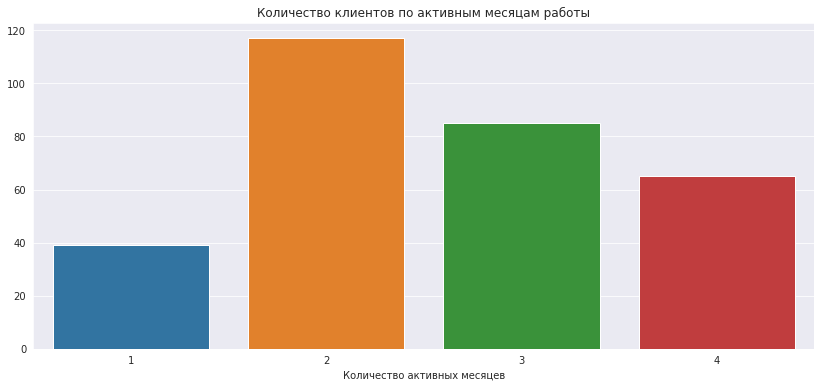

,months_count,users_count
0,1,39
1,2,117
2,3,85
3,4,65


In [42]:
create_barchart(month_stat, 
                x='months_count', 
                y='users_count', 
                xlabel='Количество активных месяцев',
                ylabel='',
                title='Количество клиентов по активным месяцам работы')

month_stat

Как видим из полученных значенией, наибольшее количество клиентов пользовались в течении 2-х месяцев (117) из рассматриваемого периода, а в течении 4-х месяцев активно пользовались только 65 клиентов, Около 85 клиентов пользуются связью в течении 3-месяцев, ну 39 пользователей в течении 1-го месяца. Ввиду того, что рассматриваемый период происходит с апреля по ноябрь (4 месяца), стоит не учитыватьв анализе клиентов которые пользовались услугами связи в течении 1 и 2 месяцев, так как эти данные могут внести погрешность, переплачивает клиент или нет.

Соответственно, для дальнейшего анализа, стоит обратить внимание на клиентов которые пользуются телефонной связью 3 и 4 месяца соответственно, из этих клиентов мы сможем рационально оценить, часто ли переплачивает клиент.

### Количество звонков клиентами

In [43]:
calls_stat = data.groupby(by=['user_id', 'tariff_plan', 'month_name'], as_index=False).agg({'calls_count': 'sum'})
calls_stat

,user_id,tariff_plan,month_name,calls_count
0,166377,B,August,977
1,166377,B,November,1314
2,166377,B,October,1406
3,166377,B,September,1452
4,166391,C,August,18
...,...,...,...,...
783,168583,B,October,1
784,168598,C,November,102
785,168601,C,November,692
786,168603,B,November,15


In [44]:
calls_stat['calls_count'].describe()

count      788.000000
mean       840.366751
std       4074.355821
min          1.000000
25%         12.750000
50%         66.000000
75%        408.000000
max      71222.000000
Name: calls_count, dtype: float64

Выведем распредление в виде гистограммы.

Создадим функцию для постраения гистограммы

In [45]:
def create_histplot(df, x, bins=10, discrete=False, title='', xlabel='', ylabel='', figsize=(18, 6)):
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize=figsize)
    sns.histplot(data=df, 
                 x=x, 
                 bins=bins, 
                 discrete=discrete,
                 ax=ax)
    ax.set(title=title, 
           xlabel=xlabel, 
           ylabel=ylabel)
    plt.show();

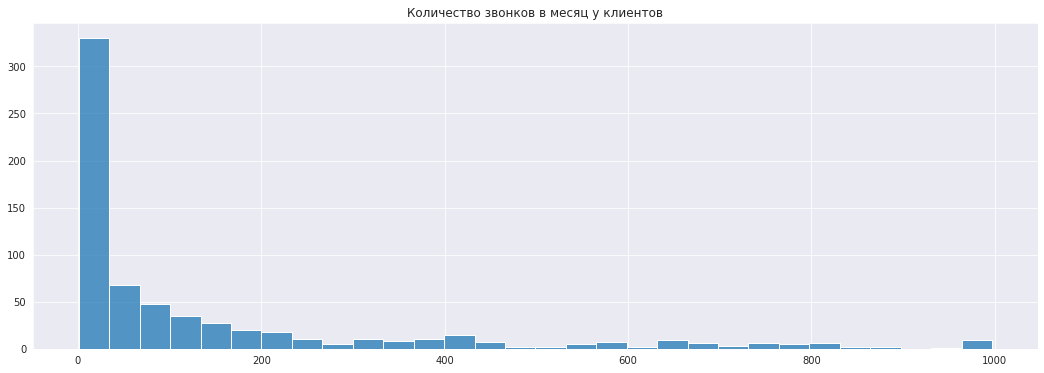

In [46]:
create_histplot(calls_stat.query('calls_count<1000'), # для лаконичности графика, ограничил кол-во звонков 1000
                x='calls_count', 
                bins=30, 
                title='Количество звонков в месяц у клиентов')

Как видим, большинство клиентов укладываются в 408 звонков в месяц

#### Количество по тарифам

Посмотрим распределение звонков по тарифам.

Ввиду того, что в дальнейшем мы будем рассматривать и по другим параметрам напишем фуннкцию для потроения "боксплотов"

In [47]:
def create_boxplots(df, x, y, order=None, title='', xlabel='', ylabel='', figsize=(18, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.boxplot(data=df, 
                x=x, 
                y=y,
                order=order)
    ax.set(title=title, 
           xlabel=xlabel, 
           ylabel=ylabel)
    plt.show();

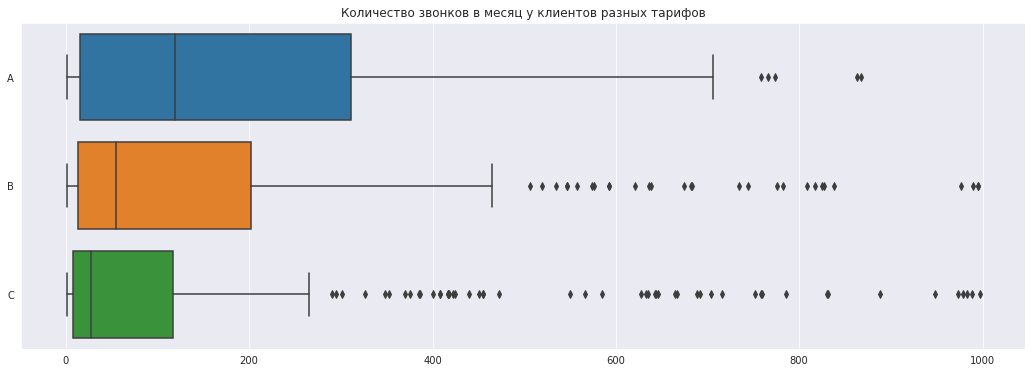

In [48]:
create_boxplots(calls_stat.query('calls_count<1000'), 
                x='calls_count', 
                y='tariff_plan', 
                order=['A', 'B', 'C'],
                title='Количество звонков в месяц у клиентов разных тарифов')

По тарифу А:  
медианное значение 150  


По тарифу В:  
медианное значение 96  


По тарифу C:  
медианное значение 38  
Чаще всего, звонят клиенты по тарифу А.  

#### Внешние и внутренние звонки

Посмотрим на распределение звонков на внешние и внутренние звонки.

In [49]:
internal_calls_stat = (data[data['internal'].notna()].groupby(by=['user_id', 'month_name', 'internal'], as_index=False)
                             .agg({'calls_count':'sum'}))

internal_calls_stat['internal'] = (internal_calls_stat['internal'].astype(bool).replace({True: 'Internal',False: 'External'}))

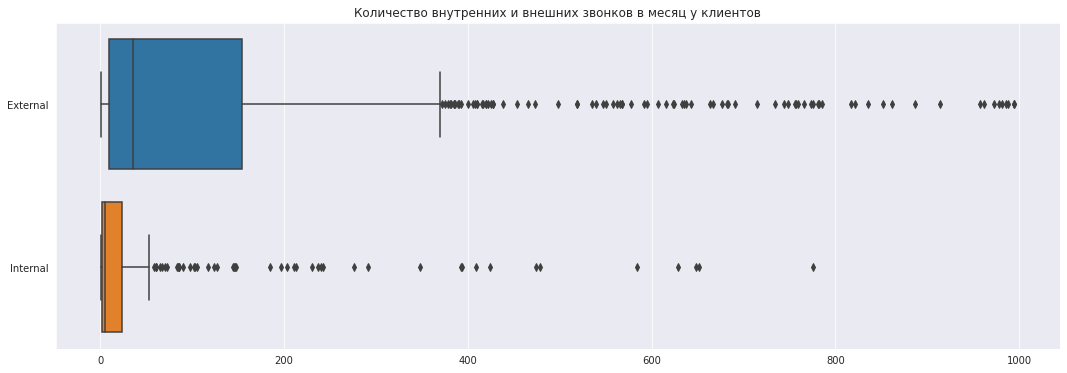

In [50]:
create_boxplots(internal_calls_stat.query('calls_count<1000'), 
                x='calls_count', 
                y='internal', 
                title='Количество внутренних и внешних звонков в месяц у клиентов')

Внешние звонки:  
  
среднее значение 822  
медианное значение 61  
Внутренние звонки:  
  
среднее значение 44  
медианное значение 5    
Очевидно, клиенты чаще звонят за пределы компании, чем пользуются внутренней связью.  

#### Входящие и исходящие звонки

Посмотрим на распределение количества входящих и исходящих звонков.

In [51]:
direction_calls_stat = data.groupby(by=['user_id', 'month_name', 'direction'], as_index=False).agg({'calls_count': 'sum'})
direction_calls_stat

,user_id,month_name,direction,calls_count
0,166377,August,in,46
1,166377,August,out,931
2,166377,November,in,52
3,166377,November,out,1262
4,166377,October,in,52
...,...,...,...,...
1286,168601,November,out,587
1287,168603,November,in,1
1288,168603,November,out,14
1289,168606,November,in,11


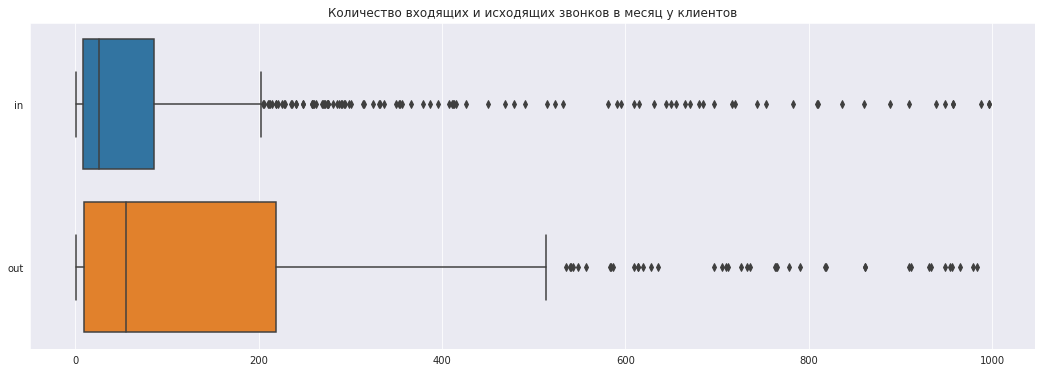

In [52]:
create_boxplots(direction_calls_stat.query('calls_count<1000'), 
                x='calls_count', 
                y='direction', 
                title='Количество входящих и исходящих звонков в месяц у клиентов')

Входящие звонки:  
- среднее значение 244  
- медианное значение 28  
  
Исходящие звонки:  
- среднее значение 921  
- медианное значение 96  
  
Чаще операторы сами звонят, чем принимают входящие звонки.  

#### Динамика по месяцам

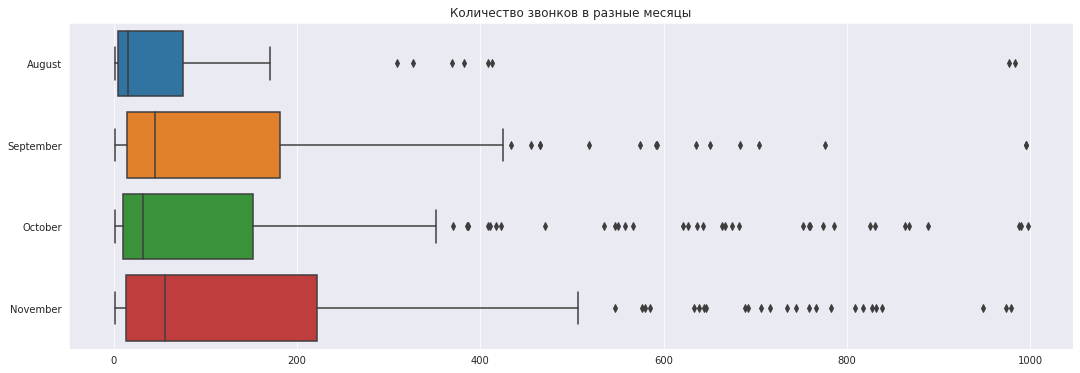

In [53]:
create_boxplots(calls_stat.query('calls_count<1000'), 
                x='calls_count', 
                y='month_name',
                order=['August', 'September', 'October', 'November'],
                title='Количество звонков в разные месяцы')

Звонков в Августе:
- среднее значение 179
- медианное значение 19

Звонков в Сентябре:
- среднее значение 491
- медианное значение 60


Звонков в Октябре:
- среднее значение 944
- медианное значение 71


Звонков в Ноябре:
- среднее значение 1175
- медианное значение 93

Такое распределение в принципе логично, поскольку добовляются новые клиенты из-за дня в день.

**ДОПОЛНЕНИЕ К ВЫВОДУ**

При анализе данных видно, что с каждым последующим месяцем начиная с августа, среднее/медианное значение увеличивается. Это объясняется тем, что в этот период подключается больше новых клиентов, что ведет к увеличению общего среднего/медианного значения. Если рассмотреть только клиентов, которые пользовались услугами телефонии в течение одного месяца (начиная с ноября), выборка по оплате за тариф будет недостаточной. Аналогичная ситуация и с клиентами, которые начали пользоваться мобильной связью в октябре, поскольку двухмесячная оплата также не даёт полной картины.

**`"Активные" клиенты`** - пользователи которые пользуются мобильной связью 3 и более месяца.

### Анализ длительности звонков клиентов

#### Общая длительность звонков

In [54]:
duration_stat = (data.groupby(by=['user_id', 'tariff_plan', 'month_name'], as_index=False)
                                                         .agg({'total_call_duration_min':'sum'}))
duration_stat.describe()

,user_id,total_call_duration_min
count,788.000000,788.000000
mean,167292.747462,948.349725
std,589.127681,3986.894428
min,166377.000000,0.000000
25%,166812.000000,4.591667
50%,167175.000000,59.433333
75%,167761.250000,488.200000
max,168606.000000,72886.400000


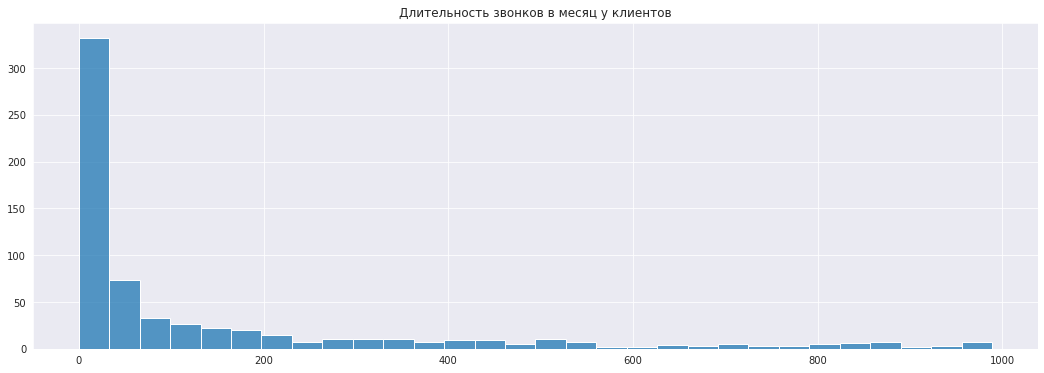

In [55]:
create_histplot(duration_stat.query('total_call_duration_min<1000'), 
                x='total_call_duration_min', 
                bins=30, 
                title='Длительность звонков в месяц у клиентов')

In [56]:
duration_stat.describe() 

,user_id,total_call_duration_min
count,788.000000,788.000000
mean,167292.747462,948.349725
std,589.127681,3986.894428
min,166377.000000,0.000000
25%,166812.000000,4.591667
50%,167175.000000,59.433333
75%,167761.250000,488.200000
max,168606.000000,72886.400000


По результату видим, что средняя месячная длительность разговоров 948 минут, а медианна 59 минут. Но стоит обратить внимание, что есть клиенты которые не разговаривают по телефону.

#### Длительность разговоров по разным тарифам

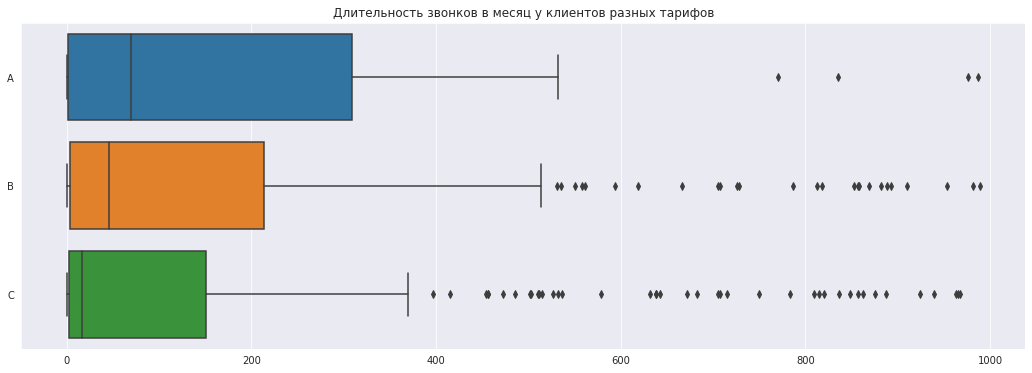

In [57]:
create_boxplots(duration_stat.query('total_call_duration_min<1000'), 
                x='total_call_duration_min', 
                y='tariff_plan', 
                order=['A', 'B', 'C'],
                title='Длительность звонков в месяц у клиентов разных тарифов')

In [58]:
#duration_stat.query('tariff_plan == "C"').describe() 

По тарифу А:  
- средняя длительность звонков состовляет 3390  
- медианное значение 172  
  
  
По тарифу В:   
- средняя длительность звонков состовляет 759  
- медианное значение 87  
  
  
По тарифу C:  
- средняя длительность звонков состовляет 550  
- медианное значение 39  
  

чаще всего люди любят говорить по тарифу А.  

#### длительность внутренних и внешних звонков

In [59]:
internal_duration_stat = (data[data['internal'].notna()].groupby(by=['user_id', 'month', 'internal'], as_index=False)
                                                                                  .agg({'total_call_duration_min':'sum'}))

internal_duration_stat['internal'] = (internal_duration_stat['internal'].astype(bool)
                                                              .replace({True: 'Internal',False: 'External'}))

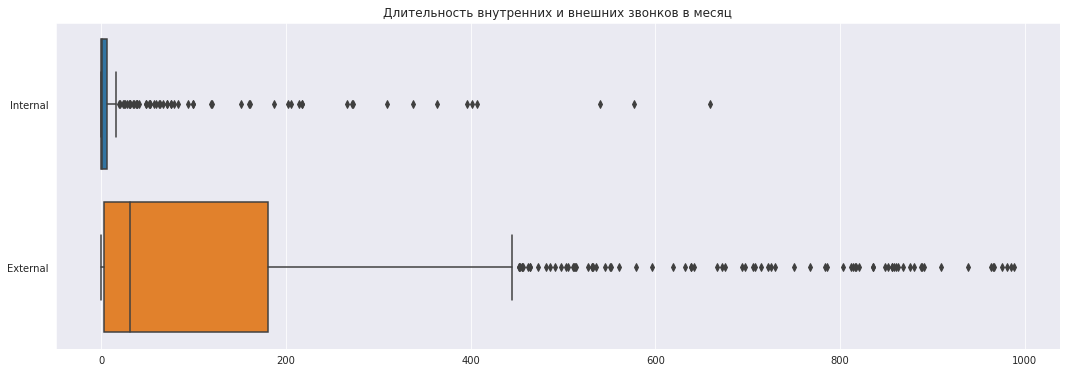

In [60]:
create_boxplots(internal_duration_stat.query('total_call_duration_min<1000'), 
                x='total_call_duration_min', 
                y='internal', 
                title='Длительность внутренних и внешних звонков в месяц')

In [61]:
#internal_duration_stat.query('internal == "External"').describe() 

Внешние звонки:  
- средняя длительность разговоров 934  
- медианная длительность разговоров 58  
  
  
Внутренние звонки:  
- средняя длительность разговоров 36  
- медианная длительность разговоров 1  

#### Длительность входящих и исходящих звонков за месяц

In [62]:
direction_duration_stat = (data.groupby(by=['user_id', 'month', 'direction'], as_index=False)
                                                               .agg({'total_call_duration_min':'sum'}))
#direction_duration_stat

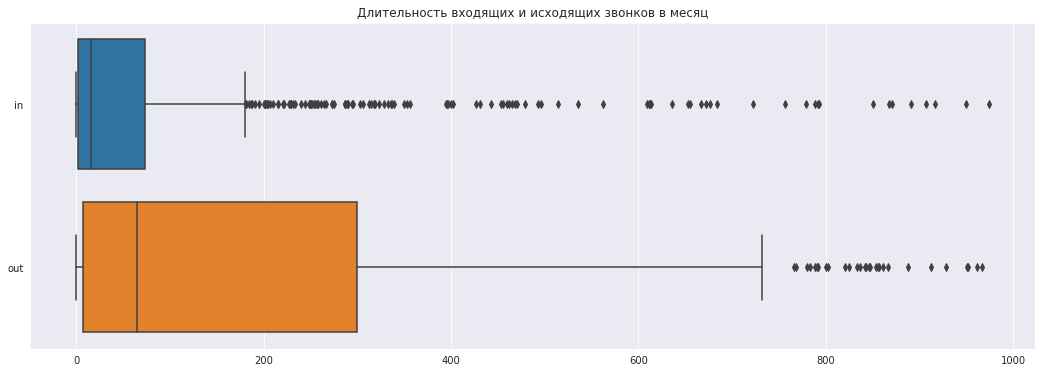

In [63]:
create_boxplots(direction_duration_stat.query('total_call_duration_min<1000'), 
                x='total_call_duration_min', 
                y='direction', 
                title='Длительность входящих и исходящих звонков в месяц')

In [64]:
#direction_duration_stat.query('direction == "in"').describe() 

Входящие звонки:  
- средняя длительность разговоров 258  
- медианная длительность разговоров 21  
  
Исходящие звонки:  
- средняя длительность разговоров 1066  
- медианная длительность разговоров 127  

#### По месяцам

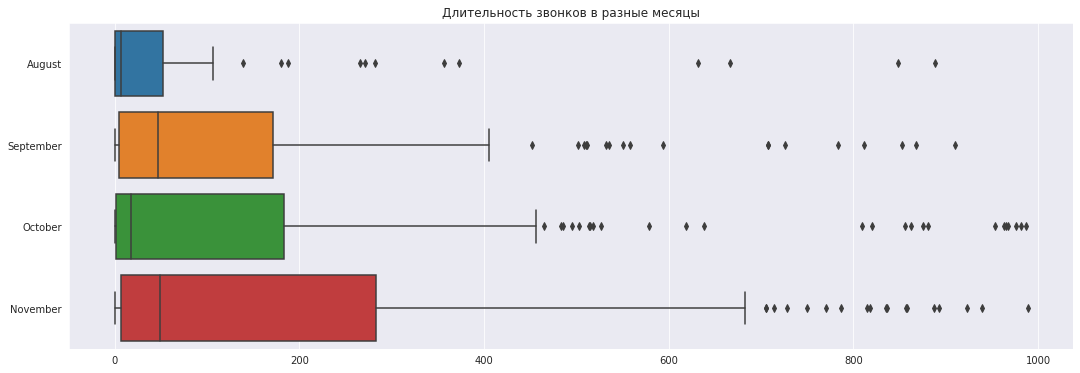

In [65]:
create_boxplots(duration_stat.query('total_call_duration_min<1000'), 
                x='total_call_duration_min', 
                y='month_name', 
                order=['August', 'September', 'October', 'November'],
                title='Длительность звонков в разные месяцы')

In [66]:
#duration_stat.query('month_name == "September"').describe()

Звонков в Августе:
- средняя длительность разговоров240
- медианная длительность разговоров 8

Звонков в Сентябре:
- средняя длительность разговоров 646
- медианная длительность разговоров 59


Звонков в Октябре:
- средняя длительность разговоров 988
- медианная длительность разговоров 58


Звонков в Ноябре:
- средняя длительность разговоров 1334
- медианная длительность разговоров 102

### Анализ количества операторов

#### общая статистика

In [67]:
operators_stat = (data.groupby(by=['user_id', 'month_name', 'tariff_plan'], as_index=False)
                                                          .agg({'operator_id': pd.Series.nunique}))

operators_stat.rename(columns={'operator_id': 'operators_count'}, inplace=True)

operators_stat['operators_count'] = operators_stat['operators_count'].astype(int)

operators_stat['operators_count'].describe()

count    788.000000
mean       2.677665
std        4.325118
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       48.000000
Name: operators_count, dtype: float64

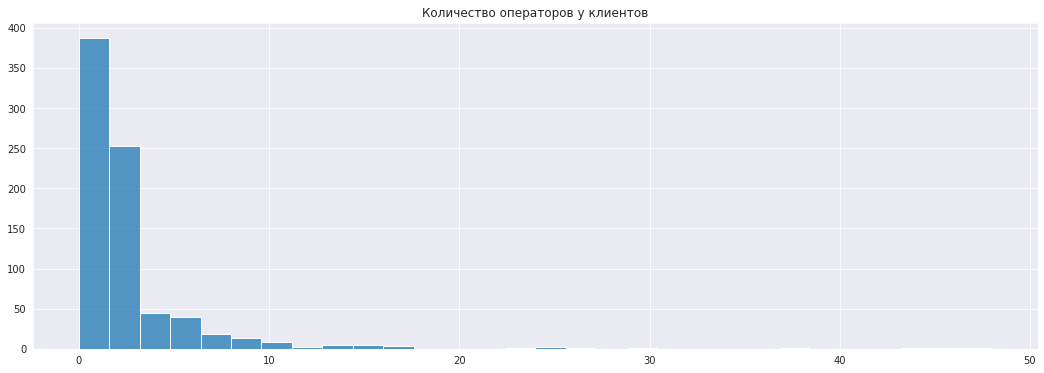

In [68]:
create_histplot(operators_stat, 
                x='operators_count', 
                bins=30, 
                title='Количество операторов у клиентов')

Среднее значение количества операторов у клиента 3, медианное значение 2. Максимально 48.

#### Статистика по тарифам

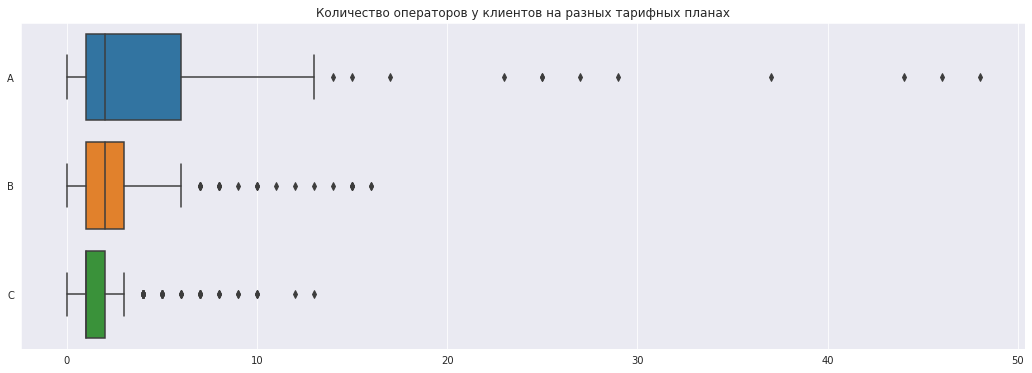

In [69]:
create_boxplots(operators_stat, 
                x='operators_count', 
                y='tariff_plan',
                order=['A', 'B', 'C'],
                title='Количество операторов у клиентов на разных тарифных планах')

In [70]:
#operators_stat.query('tariff_plan == "C"').describe() 

По тарифу А:
- среднее количество операторов 6
- медианное значение количества операторов 2 


По тарифу В:
- среднее количество операторов 2
- медианное значение количества операторов 2 


По тарифу C:
- среднее количество операторов 1.9 (2)
- медианное значение количества операторов 1

#### Статистика по месяцам

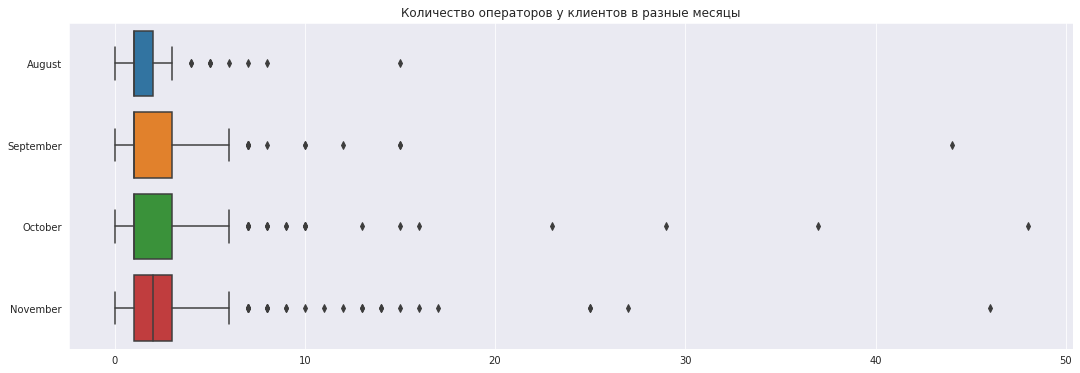

In [71]:
create_boxplots(operators_stat, 
                x='operators_count', 
                y='month_name', 
                order=['August', 'September', 'October', 'November'],
                title='Количество операторов у клиентов в разные месяцы')

In [72]:
operators_stat.query('month_name == "November"').describe() 

,user_id,operators_count
count,260.000000,260.000000
mean,167502.600000,3.003846
std,623.910517,4.598554
min,166377.000000,0.000000
25%,166984.500000,1.000000
50%,167513.500000,2.000000
75%,168018.250000,3.000000
max,168606.000000,46.000000


Звонков в Августе:
- среднее количество операторов 1.85 (2)
- медианное значение количества операторов 1

Звонков в Сентябре:
- среднее количество операторов 2.55 (3)
- медианное значение количества операторов 1


Звонков в Октябре:
- среднее количество операторов 2.7 (3)
- медианное значение количества операторов 1


Звонков в Ноябре:
- среднее количество операторов 3
- медианное значение количества операторов 2 

**ПРЕДИСЛОВИЕ К ВЫБОРУ АКТИВНЫХ КЛИЕНТОВ:**

Проведенный анализ данных выявил необходимость провести очистку данных для более точного анализа переплат клиентов. В процессе анализа было обнаружено большое количество выбросов, включающих следующие факторы:
1. Клиенты, которые пользуются услугами мобильной связи более 3 месяцев, включая последний месяц периода.
2. Наличие работающих операторов(у клиента есть работающие операторы).


#### Исключаем клиентов которые пользуются связью менее 3-х месяцев

In [73]:
# соберем таблицу по id пользователей 
users_months_count = data.groupby(by='user_id', as_index=False).agg({'month': pd.Series.nunique})

users_3months = users_months_count.query('month >= 3')['user_id']

In [74]:
# Выделение пользователей, у которых последняя дата использования услуг - ноябрь
users_last_month = data.groupby(by='user_id', as_index=False).agg({'month':'max'})

users_november = users_last_month.query('month == 11')['user_id']

#### исключение по медиане

In [75]:
# Подсчет медиан количества и длительности звонков
calls_count_median = calls_stat['calls_count'].median()
total_call_duration_median = duration_stat['total_call_duration_min'].median()

users_median_calls = (calls_stat.query('calls_count >= @calls_count_median')['user_id'].unique())

users_median_dur = (duration_stat.query('total_call_duration_min >= @total_call_duration_median')['user_id'].unique())

Полученные выше таблицы позволяют выделить пользователей которые подходят для дальнейшего анализа.

In [76]:
# Пересечение всех найденных пользователей

# Принимая во внимание твоё замечание относительно п.3
#active_users_ids = np.intersect1d(np.intersect1d(np.intersect1d(users_3months, users_median_calls), 
#                                                 users_median_dur), users_november)

active_users_ids = np.intersect1d(users_3months,users_november)


active_users_ids

array([166377, 166391, 166392, 166405, 166406, 166407, 166428, 166482,
       166485, 166487, 166495, 166503, 166511, 166520, 166533, 166536,
       166541, 166548, 166585, 166604, 166609, 166619, 166636, 166649,
       166658, 166660, 166669, 166677, 166678, 166680, 166688, 166691,
       166692, 166697, 166708, 166711, 166713, 166717, 166725, 166726,
       166732, 166774, 166782, 166800, 166803, 166812, 166813, 166833,
       166836, 166837, 166839, 166843, 166879, 166884, 166896, 166899,
       166901, 166916, 166940, 166971, 166973, 166974, 166975, 166983,
       166985, 166997, 167002, 167003, 167004, 167031, 167035, 167052,
       167059, 167061, 167071, 167077, 167078, 167079, 167082, 167102,
       167109, 167110, 167112, 167150, 167158, 167162, 167172, 167175,
       167176, 167180, 167185, 167188, 167199, 167200, 167235, 167238,
       167246, 167250, 167263, 167264, 167265, 167272, 167275, 167277,
       167286, 167338, 167359, 167402, 167412, 167436, 167445, 167451,
      

тут мы определили уникальных пользователей, которые пользуются мобильной связью 3 и более месяца

In [77]:
print('Количество активных пользователей:', len(active_users_ids))

Количество активных пользователей: 139


In [78]:
print('Доля активных пользователей от общего числа:', round(100 * len(active_users_ids) / data['user_id'].nunique(), 2))

Доля активных пользователей от общего числа: 45.42


**ВЫВОД**

Мы выявили, что считаются **`"Активными" пользователями`** - 139 человек из общего числа пользователей мобильной связи. Доля этих активных пользователей составляет 45.42% от общего числа.

## Анализ расходов компании

Для дальнейшего анализа и простоты расчета, определим сумму расходов по каждому тарифу для клиентов.

Перейдем к анализу расходов клиентов. Для всех клиентов мы рассчитаем сумму расходов за каждый месяц по каждому из существующих тарифов.

Для активных клиентов мы также определим:

- оптимальный тариф
- подсчитаем разницу между оптимальным и реальным тарифом

На основе расчетов определим, как изменится выручка заказчика.

In [79]:
tariffs_dict = {'tariff_plan': ['A', 'B', 'C'],
                'price_month': [4000, 2000, 1000],
                'incoming_price': [0, 0, 0],
                'outgoing_external_price': [0.3, 0.5, 0.7],
                'outgoing_internal_limit': [2000, 500, 0],
                'outgoing_internal_price': [0.1, 0.15, 0.3],
                'operator_price': [50, 150, 300]
                }

tariffs = pd.DataFrame(tariffs_dict)
tariffs

,tariff_plan,price_month,incoming_price,outgoing_external_price,outgoing_internal_limit,outgoing_internal_price,operator_price
0,A,4000,0,0.3,2000,0.10,50
1,B,2000,0,0.5,500,0.15,150
2,C,1000,0,0.7,0,0.30,300


Агрегируем данные клиентов по месяцам, затем для каждого месяца рассчитаем, во сколько обойдется каждый из тарифов.


Ввиду пофторения расчета для каждого тарифа, создадим функцию для расчета, где будем учитывать все лимиты установленного тарифа:
- стоимость звонков сверхлимита
- звонки другим операторам
- дополнительную плату 

In [80]:
def calculate_cost(calls_df, tariff_details):

    # определяем количество операторов у клиента в каждом месяце
    operators_stat = (
        calls_df.groupby(['user_id', 'month'],
                     as_index=False)
        .agg({'operator_id': pd.Series.nunique})
        .rename(columns={'operator_id': 'operator_count'})
    )
    
    # вычисляем продолжительность звонков
    calls_stat = (
        calls_df.groupby(['tariff_plan',
                          'user_id',
                          'month',
                          'direction',
                          'internal'],
                         as_index=False)
        .agg({'total_call_duration_min': 'sum'})
    )
    
    merged_df = operators_stat.merge(calls_stat, 
                                     on=['user_id', 'month'], 
                                     how='left')
    # Количество минут сверх лимита
    merged_df['over_limit_minutes'] = (
        merged_df.loc[(merged_df['direction']=='out')
                      & (merged_df['internal']==True),
                      'total_call_duration_min'] -
        tariff_details['outgoing_internal_limit']
    )
    
    # Все, что меньше или равно 0 заменим на 0
    merged_df.loc[(merged_df['over_limit_minutes']<=0)
                  | (merged_df['over_limit_minutes'].isna()), 
                 'over_limit_minutes'] = 0
    
    # Плата за исходящие внутренние сверх лимита
    merged_df['over_limit_cost'] = (
        merged_df['over_limit_minutes'] * 
        tariff_details['outgoing_internal_price']
    )
    
    # Плата за исходящие внешние
    
    merged_df['outgoing_external_cost'] = (
        merged_df.loc[(merged_df['direction']=='out')
                      & (merged_df['internal']==False),
                      'total_call_duration_min'] *  
        tariff_details['outgoing_external_price']
    )
    
    # Все, что меньше или равно 0 заменим на 0
    merged_df.loc[(merged_df['outgoing_external_cost']<=0)
                  | (merged_df['outgoing_external_cost'].isna()), 
                 'outgoing_external_cost'] = 0
    
    # Плата за операторов
    merged_df['operators_cost'] = (
        merged_df['operator_count'] * tariff_details['operator_price']
    )
    
    # Ежемесячная плата
    merged_df['month_cost'] = tariff_details['price_month']
    
    # Результирующий датафрейм
    result_df = (
        merged_df.groupby(['user_id',
                           'month'],
                          as_index=False)
        .agg({'over_limit_cost': 'max',
              'outgoing_external_cost': 'max',
              'operators_cost': 'max',
              'month_cost': 'max'})
    )
    
    #Полная стоимость
    result_df['total_cost'] = (
        result_df[['over_limit_cost',
                   'outgoing_external_cost',
                   'operators_cost',
                   'month_cost']].sum(axis=1)
        .astype(float)
    )
    
    result_df['tariff_plan'] = tariff_details['tariff_plan']
    
    return result_df

In [81]:
costs_a = calculate_cost(calls_df=data, tariff_details=tariffs.loc[0, :])
costs_b = calculate_cost(calls_df=data, tariff_details=tariffs.loc[1, :])
costs_c = calculate_cost(calls_df=data, tariff_details=tariffs.loc[2, :])

In [82]:
# Объединяем датафреймы
costs_full = (
    costs_a.merge(costs_b, on=['user_id', 'month'], suffixes=['_A', '_B'])
    .merge(costs_c, on=['user_id', 'month'])
    .merge(clients, on='user_id', suffixes=['', '_actual'])
    .rename(columns={'total_cost': 'total_cost_C'})
)

# Оставим только нужные для сравнения столбцы
costs_full = costs_full[['user_id', 
                         'month', 
                         'total_cost_A', 
                         'total_cost_B', 
                         'total_cost_C',
                         'tariff_plan_actual']]

In [83]:
costs_full.head()

,user_id,month,total_cost_A,total_cost_B,total_cost_C,tariff_plan_actual
0,166377,8,4640.145,3400.241667,3410.818333,B
1,166377,9,4729.175,3481.958333,3434.786667,B
2,166377,10,4746.035,3576.725000,3657.440000,B
3,166377,11,4676.920,3394.866667,3313.448333,B
4,166391,8,4100.000,2300.000000,1600.035000,C


**ВЫВОД**

Мы теперь имеем набор данных, который позволяет нам увидеть, сколько каждый клиент должен заплатить за каждый тариф, независимо от того, какой тариф он использует. 

В отдельном столбце указан текущий тариф клиента.


    
    На основе данных одного клиента мы рассчитываем стоимость его услуг, включая звонки другому оператору и плату за превышение тарифного плана. Затем мы сравниваем эти суммы с текущей оплатой клиента и определяем оптимальный тариф для него из трех возможных вариантов. Мы также добавляем флажок или индикатор, указывающий, совпадает ли текущий тариф клиента с оптимальным вариантом.
    


Опишу методтку выбора тарифа

<div style="background-color:black; color:#ffffff; text-align:center; padding:2%">
    
**Методика определения:** 
    
1. Проводим расчёт, какую сумму должен заплатить клиент (не привязываясь к его текущему тарифу) по каждому из трех тарифов
2. Расчет проводим для всех клиентов (позже отфильтруем по активным клиентам)
3. Среди полученных значений плат за тарифы для клиентов, находим оптимальный (т.е с наименьшей платой)
    - платы по тарифам мы расчитываем на основании данных использования трафика.
4. Проверяем совпадает ли оптимальный тариф с текущим.
5. Устанавливаем флажок соответствия отимального тарифа или нет.
6. Так как клиенты опдачивают несколько месяцев (3 или 4), определим на какой процент у них происходит переплата
    - в случа если процент будет равняться нулю - тогда у клиента оптимально подобранный тариф

**НОВОЕ ПРЕДИСЛОВИЕ К ПУНКТУ**

Ранее мы подсчитали какие затарты будут у клиента в зависимости от тарифа (не зависимо от текущего). Теперь, найдем из расчитаных значений - оптимальный для клиента и сравним его с текущим тарифом. В случае совпадения установим булевой флажок совпадения оптимального и текущего тарифа.

In [84]:
# Выбираем среди трех стоимостей наименьшую - оптимальную
costs_full['tariff_plan_optimal'] = (
    costs_full[['total_cost_A', 'total_cost_B', 'total_cost_C']].idxmin(axis='columns')
    .str[-1]
)

costs_full['cost_optimal'] = costs_full[['total_cost_A', 'total_cost_B', 'total_cost_C']].min(axis='columns')

# Добавляем флаг того, совпадает ли реальный тарифный план с оптимальным
costs_full['plans_match'] = costs_full['tariff_plan_actual'] == costs_full['tariff_plan_optimal']

In [85]:
costs_full.head(10)

,user_id,month,total_cost_A,total_cost_B,total_cost_C,tariff_plan_actual,tariff_plan_optimal,cost_optimal,plans_match
0,166377,8,4640.145,3400.241667,3410.818333,B,B,3400.241667,True
1,166377,9,4729.175,3481.958333,3434.786667,B,C,3434.786667,False
2,166377,10,4746.035,3576.725000,3657.440000,B,B,3576.725000,True
3,166377,11,4676.920,3394.866667,3313.448333,B,C,3313.448333,False
4,166391,8,4100.000,2300.000000,1600.035000,C,C,1600.035000,True
5,166391,9,4050.000,2150.000000,1300.000000,C,C,1300.000000,True
6,166391,10,4000.000,2000.000000,1000.000000,C,C,1000.000000,True
7,166391,11,4050.000,2150.000000,1300.000000,C,C,1300.000000,True
8,166392,8,4100.000,2300.000000,1600.000000,C,C,1600.000000,True
9,166392,9,4100.000,2300.000000,1600.000000,C,C,1600.000000,True


In [86]:
costs_full['cost_actual'] = 0

costs_full.loc[costs_full['tariff_plan_actual'] == 'A', 
               'cost_actual'] = costs_full['total_cost_A']
costs_full.loc[costs_full['tariff_plan_actual'] == 'B', 
               'cost_actual'] = costs_full['total_cost_B']
costs_full.loc[costs_full['tariff_plan_actual'] == 'C', 
               'cost_actual'] = costs_full['total_cost_C']

costs_full

,user_id,month,total_cost_A,total_cost_B,total_cost_C,tariff_plan_actual,tariff_plan_optimal,cost_optimal,plans_match,cost_actual
0,166377,8,4640.145,3400.241667,3410.818333,B,B,3400.241667,True,3400.241667
1,166377,9,4729.175,3481.958333,3434.786667,B,C,3434.786667,False,3481.958333
2,166377,10,4746.035,3576.725000,3657.440000,B,B,3576.725000,True,3576.725000
3,166377,11,4676.920,3394.866667,3313.448333,B,C,3313.448333,False,3394.866667
4,166391,8,4100.000,2300.000000,1600.035000,C,C,1600.035000,True,1600.035000
...,...,...,...,...,...,...,...,...,...,...
783,168583,11,4100.000,2300.000000,1600.000000,B,C,1600.000000,False,2300.000000
784,168598,11,4050.000,2150.000000,1300.000000,C,C,1300.000000,True,1300.000000
785,168601,11,4265.960,2576.600000,1987.240000,C,C,1987.240000,True,1987.240000
786,168603,11,4055.935,2159.891667,1313.848333,B,C,1313.848333,False,2159.891667


Создаем таблицу, где будут отображены суммарные траты **активных клиентов** по всем тарифам (если они были на одном из трех тарифов пердложенных) и одновременно подсчитываем затраченную сумму клиентом на оплату 

In [87]:
costs_full_sum = pd.DataFrame(columns=[])

costs_full_sum = (costs_full.query('user_id in @active_users_ids').groupby(by='user_id', as_index=False)
 .agg({'total_cost_A':'sum', 'total_cost_B':'sum', 'total_cost_C':'sum', 'cost_actual': 'sum'}))


costs_full_sum

,user_id,total_cost_A,total_cost_B,total_cost_C,cost_actual
0,166377,18792.275,13853.791667,13816.493333,13853.791667
1,166391,16200.000,8600.000000,5200.035000,5200.035000
2,166392,16400.000,9200.000000,6400.000000,6400.000000
3,166405,21979.860,19566.433333,22357.486667,19566.433333
4,166406,18579.675,12899.458333,11677.656667,12899.458333
...,...,...,...,...,...
134,167716,12424.715,6907.858333,4541.116667,6907.858333
135,167721,12000.000,6000.000000,3000.000000,3000.000000
136,167727,13317.085,8328.475000,6439.865000,6439.865000
137,167744,12100.000,6300.000000,3600.000000,3600.000000


Добавим индификатор используемого тарифа клиентом

In [88]:
cost_comparison = costs_full_sum.merge(clients, on='user_id', how='left')
cost_comparison = cost_comparison.drop('date_start', axis=1)
cost_comparison

,user_id,total_cost_A,total_cost_B,total_cost_C,cost_actual,tariff_plan
0,166377,18792.275,13853.791667,13816.493333,13853.791667,B
1,166391,16200.000,8600.000000,5200.035000,5200.035000,C
2,166392,16400.000,9200.000000,6400.000000,6400.000000,C
3,166405,21979.860,19566.433333,22357.486667,19566.433333,B
4,166406,18579.675,12899.458333,11677.656667,12899.458333,B
...,...,...,...,...,...,...
134,167716,12424.715,6907.858333,4541.116667,6907.858333,B
135,167721,12000.000,6000.000000,3000.000000,3000.000000,C
136,167727,13317.085,8328.475000,6439.865000,6439.865000,C
137,167744,12100.000,6300.000000,3600.000000,3600.000000,C


Определяем оптимальную стоимость для каждого клиента, после чего сравниваем, совпадает ли текущий тарифный план с оптимальным (тот тариф за который пришлось заплатить меньше всего)

In [89]:
# Выбираем среди трех стоимостей наименьшую - оптимальную
cost_comparison['tariff_plan_optimal'] = (
    cost_comparison[['total_cost_A', 'total_cost_B', 'total_cost_C']].idxmin(axis='columns')
    .str[-1]
)

cost_comparison['cost_optimal'] = cost_comparison[['total_cost_A', 'total_cost_B', 'total_cost_C']].min(axis='columns')

cost_comparison
# Добавляем флаг того, совпадает ли реальный тарифный план с оптимальным
cost_comparison['plans_match'] = cost_comparison['cost_actual'] == cost_comparison['cost_optimal']
cost_comparison

,user_id,total_cost_A,total_cost_B,total_cost_C,cost_actual,tariff_plan,tariff_plan_optimal,cost_optimal,plans_match
0,166377,18792.275,13853.791667,13816.493333,13853.791667,B,C,13816.493333,False
1,166391,16200.000,8600.000000,5200.035000,5200.035000,C,C,5200.035000,True
2,166392,16400.000,9200.000000,6400.000000,6400.000000,C,C,6400.000000,True
3,166405,21979.860,19566.433333,22357.486667,19566.433333,B,B,19566.433333,True
4,166406,18579.675,12899.458333,11677.656667,12899.458333,B,C,11677.656667,False
...,...,...,...,...,...,...,...,...,...
134,167716,12424.715,6907.858333,4541.116667,6907.858333,B,C,4541.116667,False
135,167721,12000.000,6000.000000,3000.000000,3000.000000,C,C,3000.000000,True
136,167727,13317.085,8328.475000,6439.865000,6439.865000,C,C,6439.865000,True
137,167744,12100.000,6300.000000,3600.000000,3600.000000,C,C,3600.000000,True


Запишем в таблицу клиентов у которых установлен не оптимальный тариф (определяем по флажку)

In [90]:
cost_final = cost_comparison.query('plans_match == False')

Получим список клиентов у кого установлен не оптимальный тариф

In [91]:
list_user = cost_comparison.query('plans_match == False')['user_id']
list_user

0      166377
4      166406
5      166407
6      166428
10     166495
        ...  
124    167543
128    167621
130    167634
132    167654
134    167716
Name: user_id, Length: 69, dtype: int64

**ВЫВОД**

После анализа данных мы можем определить, у каких клиентов установлен оптимальный тариф, а у других клиентов может потребоваться рекомендация по смене тарифного плана.

#### Переплаты активных пользователей

In [92]:
users_match_plan_count = (costs_full.query('user_id in @active_users_ids').groupby(by='user_id', as_index=False)
                                                                                              .agg({'plans_match':'mean'}))
users_match_plan_count

,user_id,plans_match
0,166377,0.50
1,166391,1.00
2,166392,1.00
3,166405,0.25
4,166406,0.00
...,...,...
134,167716,0.00
135,167721,1.00
136,167727,1.00
137,167744,1.00


In [93]:
users_match_plan_count1 = (costs_full.query('user_id in @active_users_ids').groupby(by='user_id', as_index=False)
                                                                               .agg({'plans_match':['sum', 'count']}))
users_match_plan_count1

user_id plans_match      
                    sum count
0    166377           2     4
1    166391           4     4
2    166392           4     4
3    166405           1     4
4    166406           0     4
..      ...         ...   ...
134  167716           0     3
135  167721           3     3
136  167727           3     3
137  167744           3     3
138  167781           3     3

[139 rows x 3 columns]

In [94]:
users_match_plan_count['plans_match'] = round(100 * users_match_plan_count['plans_match'], 2)

users_match_plan_count['plans_match'].value_counts()

0.00      64
100.00    58
66.67      8
75.00      3
50.00      2
33.33      2
25.00      2
Name: plans_match, dtype: int64

In [95]:
users_match_plan_count = (costs_full.query('user_id in @active_users_ids').groupby(by='user_id', as_index=False)
                                                                                              .agg({'plans_match':'mean'}))
users_match_plan_count

,user_id,plans_match
0,166377,0.50
1,166391,1.00
2,166392,1.00
3,166405,0.25
4,166406,0.00
...,...,...
134,167716,0.00
135,167721,1.00
136,167727,1.00
137,167744,1.00


In [96]:
users_match_plan_count1 = (costs_full.query('user_id in @active_users_ids').groupby(by='user_id', as_index=False)
                                                                               .agg({'plans_match':['sum', 'count']}))
users_match_plan_count1

user_id plans_match      
                    sum count
0    166377           2     4
1    166391           4     4
2    166392           4     4
3    166405           1     4
4    166406           0     4
..      ...         ...   ...
134  167716           0     3
135  167721           3     3
136  167727           3     3
137  167744           3     3
138  167781           3     3

[139 rows x 3 columns]

In [97]:
users_match_plan_count['plans_match'] = round(100 * users_match_plan_count['plans_match'], 2)

users_match_plan_count['plans_match'].value_counts()

0.00      64
100.00    58
66.67      8
75.00      3
50.00      2
33.33      2
25.00      2
Name: plans_match, dtype: int64

In [98]:
#len(users_match_plan_count)

In [99]:
costs_full

,user_id,month,total_cost_A,total_cost_B,total_cost_C,tariff_plan_actual,tariff_plan_optimal,cost_optimal,plans_match,cost_actual
0,166377,8,4640.145,3400.241667,3410.818333,B,B,3400.241667,True,3400.241667
1,166377,9,4729.175,3481.958333,3434.786667,B,C,3434.786667,False,3481.958333
2,166377,10,4746.035,3576.725000,3657.440000,B,B,3576.725000,True,3576.725000
3,166377,11,4676.920,3394.866667,3313.448333,B,C,3313.448333,False,3394.866667
4,166391,8,4100.000,2300.000000,1600.035000,C,C,1600.035000,True,1600.035000
...,...,...,...,...,...,...,...,...,...,...
783,168583,11,4100.000,2300.000000,1600.000000,B,C,1600.000000,False,2300.000000
784,168598,11,4050.000,2150.000000,1300.000000,C,C,1300.000000,True,1300.000000
785,168601,11,4265.960,2576.600000,1987.240000,C,C,1987.240000,True,1987.240000
786,168603,11,4055.935,2159.891667,1313.848333,B,C,1313.848333,False,2159.891667


In [100]:
costs_full['plans_match'].count()

788

In [101]:
costs_full['user_id'].value_counts().count()

306

Добавим столбец с ценой, которую клиент заплатит в реальности в соответствии со своим тарифом, и подсчитаем разницу.

In [102]:
costs_full['cost_actual'] = 0
costs_full

,user_id,month,total_cost_A,total_cost_B,total_cost_C,tariff_plan_actual,tariff_plan_optimal,cost_optimal,plans_match,cost_actual
0,166377,8,4640.145,3400.241667,3410.818333,B,B,3400.241667,True,0
1,166377,9,4729.175,3481.958333,3434.786667,B,C,3434.786667,False,0
2,166377,10,4746.035,3576.725000,3657.440000,B,B,3576.725000,True,0
3,166377,11,4676.920,3394.866667,3313.448333,B,C,3313.448333,False,0
4,166391,8,4100.000,2300.000000,1600.035000,C,C,1600.035000,True,0
...,...,...,...,...,...,...,...,...,...,...
783,168583,11,4100.000,2300.000000,1600.000000,B,C,1600.000000,False,0
784,168598,11,4050.000,2150.000000,1300.000000,C,C,1300.000000,True,0
785,168601,11,4265.960,2576.600000,1987.240000,C,C,1987.240000,True,0
786,168603,11,4055.935,2159.891667,1313.848333,B,C,1313.848333,False,0


In [103]:
costs_full['cost_actual'] = 0

costs_full.loc[costs_full['tariff_plan_actual'] == 'A', 
               'cost_actual'] = costs_full['total_cost_A']
costs_full.loc[costs_full['tariff_plan_actual'] == 'B', 
               'cost_actual'] = costs_full['total_cost_B']
costs_full.loc[costs_full['tariff_plan_actual'] == 'C', 
               'cost_actual'] = costs_full['total_cost_C']

costs_full['overpaid'] = costs_full['cost_actual'] - costs_full['cost_optimal']

costs_full.head(10)

,user_id,month,total_cost_A,total_cost_B,total_cost_C,tariff_plan_actual,tariff_plan_optimal,cost_optimal,plans_match,cost_actual,overpaid
0,166377,8,4640.145,3400.241667,3410.818333,B,B,3400.241667,True,3400.241667,0.000000
1,166377,9,4729.175,3481.958333,3434.786667,B,C,3434.786667,False,3481.958333,47.171667
2,166377,10,4746.035,3576.725000,3657.440000,B,B,3576.725000,True,3576.725000,0.000000
3,166377,11,4676.920,3394.866667,3313.448333,B,C,3313.448333,False,3394.866667,81.418333
4,166391,8,4100.000,2300.000000,1600.035000,C,C,1600.035000,True,1600.035000,0.000000
5,166391,9,4050.000,2150.000000,1300.000000,C,C,1300.000000,True,1300.000000,0.000000
6,166391,10,4000.000,2000.000000,1000.000000,C,C,1000.000000,True,1000.000000,0.000000
7,166391,11,4050.000,2150.000000,1300.000000,C,C,1300.000000,True,1300.000000,0.000000
8,166392,8,4100.000,2300.000000,1600.000000,C,C,1600.000000,True,1600.000000,0.000000
9,166392,9,4100.000,2300.000000,1600.000000,C,C,1600.000000,True,1600.000000,0.000000


In [104]:
cost_final['overpaid'] = cost_final['cost_actual'] - cost_final['cost_optimal']
cost_final

/tmp/ipykernel_63/2723741580.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_final['overpaid'] = cost_final['cost_actual'] - cost_final['cost_optimal']


,user_id,total_cost_A,total_cost_B,total_cost_C,cost_actual,tariff_plan,tariff_plan_optimal,cost_optimal,plans_match,overpaid
0,166377,18792.275,13853.791667,13816.493333,13853.791667,B,C,13816.493333,False,37.298333
4,166406,18579.675,12899.458333,11677.656667,12899.458333,B,C,11677.656667,False,1221.801667
5,166407,17314.320,11790.533333,11576.916667,17314.320000,A,C,11576.916667,False,5737.403333
6,166428,16300.000,8900.000000,5800.000000,8900.000000,B,C,5800.000000,False,3100.000000
10,166495,17257.425,10495.708333,8033.991667,10495.708333,B,C,8033.991667,False,2461.716667
...,...,...,...,...,...,...,...,...,...,...
124,167543,12101.300,6302.166667,3603.033333,6302.166667,B,C,3603.033333,False,2699.133333
128,167621,12150.195,6450.325000,3900.455000,6450.325000,B,C,3900.455000,False,2549.870000
130,167634,12367.360,6812.266667,4408.158333,12367.360000,A,C,4408.158333,False,7959.201667
132,167654,13187.280,8445.466667,7053.673333,8445.466667,B,C,7053.673333,False,1391.793333


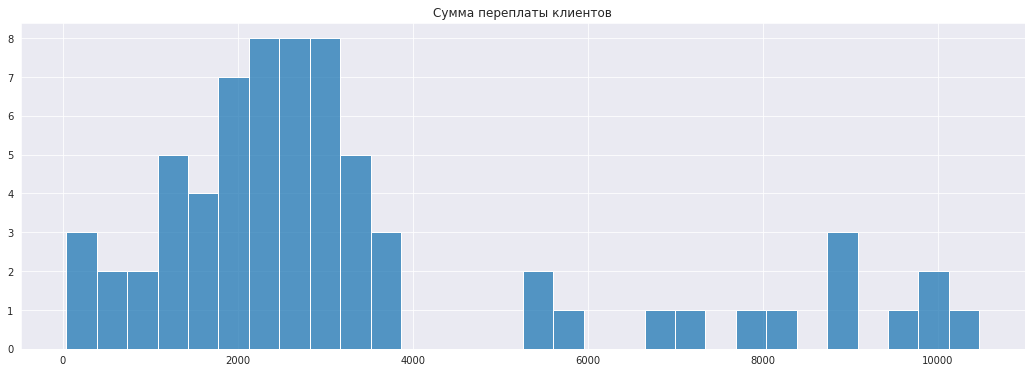

In [105]:
create_histplot(cost_final, 
                x='overpaid', 
                bins=30, 
                title='Сумма переплаты клиентов')

In [106]:
cost_final['overpaid'].describe()

count       69.000000
mean      3393.757210
std       2647.863441
min         37.298333
25%       1808.735000
50%       2550.000000
75%       3351.473333
max      10472.570000
Name: overpaid, dtype: float64


Как видим, максимальная переплата была аж в 10472 рубля, а медианное значение переплат 3393. 

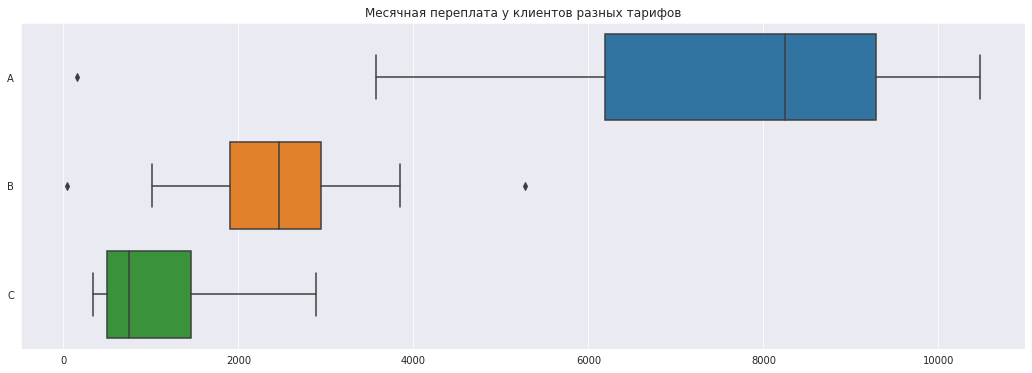

In [107]:
create_boxplots(cost_final, 
                x='overpaid', 
                y='tariff_plan', 
                order=['A', 'B', 'C'],
                title='Месячная переплата у клиентов разных тарифов')

Видим, что максимальные перплаты у клиентов на тарифе А, по сравнению с тарифами В и С.

## Анализ выручки компании

### Текущая выручка компании

Ввиду того, что необходимо определить на сколько уменьшиться выручка компании, будем смотреть только по активным клиентам

In [108]:
revenue_actual = round(cost_final['cost_actual'].sum(), 2)

print('Текущая выручка за по активным клиентам составит -', revenue_actual)

Текущая выручка за по активным клиентам составит - 748208.67


### Альтернативная выручка компании

In [109]:
revenue_basic = round(costs_full.query('month > 8 and user_id not in @active_users_ids')['cost_actual'].sum(), 2)

revenue_transfered = round(costs_full.query('month > 8 and user_id in @active_users_ids')['cost_optimal']).sum()

revenue_opt = revenue_basic + revenue_transfered

print('Потенциальная выручка за 3 месяца составит - ', round(revenue_opt, 2))

Потенциальная выручка за 3 месяца составит -  1585234.42


In [110]:
#Определим какая будет выручка в случае если клиенты перешли бы на оптимальные тарифы
revenue_opt = round(cost_final['cost_optimal'].sum(), 2)

print('Потенциальная выручка по активным клиентам в случае перехода составит -', revenue_opt)

Потенциальная выручка по активным клиентам в случае перехода составит - 514039.42


In [111]:
1 - (revenue_basic + revenue_opt) / (revenue_basic + revenue_transfered)

0.20617239688752143

***ВЫВОД***  
Потенциальная выручка всех клиентов за 3 месяца составит - 1585234.42. 
Если мы поменяем тарифы для активных клиентов выручка упадет с 748208.68 до 514039.42 (на 234169,26), а общая выручка компании снизится до 1 351 065,16.  
В относительном значении выручка упадет на 20%.





## Гипотезы

Проверим две гипотезы:
1. зависимость времени ожидания от тарифного плана:
    -  H0 - нет статистически значимой разницы между тарифами по времени ожидания ответа на входящий звонок,
    -  H1 - существует статистически значимая разница между разными тарифами по времени ожидания ответа на входящий звонок.
2. зависимость количества звонков от дня недели:
    - Н0: Количество принятых звонков операторами в  такое же, как и в остальные дни
    - Н1: Количество принятых звонков операторами в "день наиболее загруженный в неделю" и в остальные дни отличаются

Для чего мы рассматриваем даанные гипотезы, начнем по порядку:
1. Зависимость времени ожидания от тарифного плана:
    * проверяя данную зависимость, мы проверяем, зависимость от времени с ожиданием. в случае если время ожидание зависит от тарифа, тогда колл-центры не рационально используют свои тарифы из-за чего возникает дополнительные траты. Как для мобильного оператора, возмжно, в случае попытки удержания клиента, рассмотреть вариант с бесплатным ожиданием или увеличением лимита времени по тарифам.
    
    
2. Зависимость количества звонков от дня недели
    * проверяя данную гипотезу мы проверям есть ли зависимость от дня недели от количества принятых звонков операторами.
    * благодоря данной зависимости можно определить загруженость колл-центров в зависимости от дня недели, но как для оператора мобильной сети - это показывает нагрузку на сервера, но и также наиболее длительные разговоры, т.е. возможность рассмотрения каких-либо акций в тарифе для сохранения клиентов

### Зависимость времени ожидания от тарифного плана

In [112]:
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration_sec,total_call_duration_sec,tariff_plan,date_start,call_duration_min,total_call_duration_min,month,month_name
0,166377,2019-08-04,in,False,<NA>,True,2,0,4,B,2019-08-01,0.000000,0.066667,8,August
1,166377,2019-08-05,out,True,880022,True,3,0,5,B,2019-08-01,0.000000,0.083333,8,August
2,166377,2019-08-05,out,True,880020,True,1,0,1,B,2019-08-01,0.000000,0.016667,8,August
3,166377,2019-08-05,out,True,880020,False,1,10,18,B,2019-08-01,0.166667,0.300000,8,August
4,166377,2019-08-05,out,False,880022,True,3,0,25,B,2019-08-01,0.000000,0.416667,8,August


In [113]:
# Добавляем столбец, так как  он необходим для проверки гипотез
data['waiting_time'] = data['total_call_duration_min'] - data['call_duration_min']
data['avg_wait_time_per_call'] = data['waiting_time'] / data['calls_count']

In [114]:
sample_A = data[data['tariff_plan'] == 'A']['avg_wait_time_per_call']
sample_B = data[data['tariff_plan'] == 'B']['avg_wait_time_per_call']
sample_C = data[data['tariff_plan'] == 'C']['avg_wait_time_per_call']

In [115]:
# Создадим функцию для теста mannwhitneyu

def mannwhitneyu_test(a, b, c):
    alpha = 0.05
    results_AB_mannwhitneyu = st.mannwhitneyu(sample_A, sample_B)
    results_BC_mannwhitneyu = st.mannwhitneyu(sample_B, sample_C)
    results_AC_mannwhitneyu = st.mannwhitneyu(sample_A, sample_C)
    bonferroni_alpha = alpha / 3  # произведено три сравнения
    print('p-значение для сравнения групп А и B: ', results_AB_mannwhitneyu.pvalue)
    print('p-значение для сравнения групп B и C: ', results_BC_mannwhitneyu.pvalue)
    print('p-значение для сравнения групп А и C: ', results_AC_mannwhitneyu.pvalue)
    if (results_AB_mannwhitneyu.pvalue < bonferroni_alpha):
        print("Отвергаем нулевую гипотезу для сравнения тарифов А и B: разница статистически значима")
    else:
        print("Не получилось отвергнуть нулевую гипотезу для сравнения тарифов А и B")

    if (results_BC_mannwhitneyu.pvalue < bonferroni_alpha):
        print("Отвергаем нулевую гипотезу для сравнения тарифов B и C: разница статистически значима")
    else:
        print("Не получилось отвергнуть нулевую гипотезу для сравнения тарифов B и C")

    if (results_AC_mannwhitneyu.pvalue < bonferroni_alpha):
        print("Отвергаем нулевую гипотезу для сравнения тарифов А и C: разница статистически значима")
    else:
        print("Не получилось отвергнуть нулевую гипотезу для сравнения тарифов А и C")

In [116]:
mannwhitneyu_test(sample_A, sample_B, sample_C)

p-значение для сравнения групп А и B:  0.00012453752175758885
p-значение для сравнения групп B и C:  2.2304294326248526e-13
p-значение для сравнения групп А и C:  7.621199589504561e-29
Отвергаем нулевую гипотезу для сравнения тарифов А и B: разница статистически значима
Отвергаем нулевую гипотезу для сравнения тарифов B и C: разница статистически значима
Отвергаем нулевую гипотезу для сравнения тарифов А и C: разница статистически значима


### зависимость количества звонков от дня недели

Прежде чем проверить данную гипотезу, определим в какой день недели происходило наибольшее количество звонков.

In [117]:
data['day'] = pd.DatetimeIndex(data['date']).day
data['weekday'] = data['date'].dt.day_name()
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration_sec,total_call_duration_sec,tariff_plan,date_start,call_duration_min,total_call_duration_min,month,month_name,waiting_time,avg_wait_time_per_call,day,weekday
0,166377,2019-08-04,in,False,<NA>,True,2,0,4,B,2019-08-01,0.000000,0.066667,8,August,0.066667,0.033333,4,Sunday
1,166377,2019-08-05,out,True,880022,True,3,0,5,B,2019-08-01,0.000000,0.083333,8,August,0.083333,0.027778,5,Monday
2,166377,2019-08-05,out,True,880020,True,1,0,1,B,2019-08-01,0.000000,0.016667,8,August,0.016667,0.016667,5,Monday
3,166377,2019-08-05,out,True,880020,False,1,10,18,B,2019-08-01,0.166667,0.300000,8,August,0.133333,0.133333,5,Monday
4,166377,2019-08-05,out,False,880022,True,3,0,25,B,2019-08-01,0.000000,0.416667,8,August,0.416667,0.138889,5,Monday


Text(0, 0.5, 'Количество звонков')

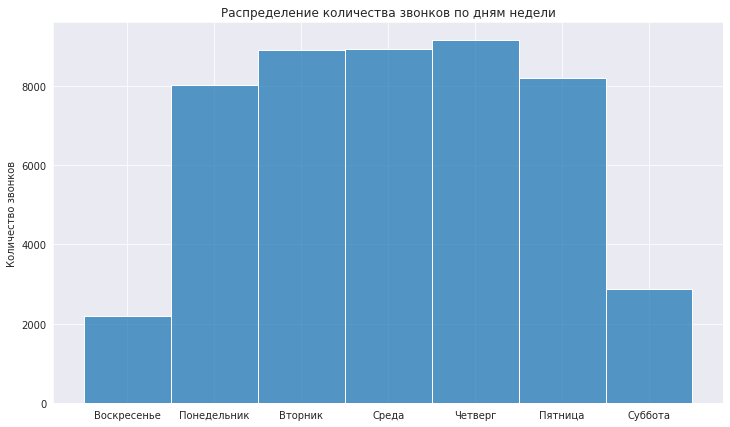

In [118]:
plt.figure(figsize=(12, 7))
ax = sns.histplot(data, x='weekday', multiple='stack')
plt.xticks(['Sunday', 'Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday','Saturday'],
           ['Воскресенье', 'Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница','Суббота'])
ax.axes.set_title('Распределение количества звонков по дням недели')
ax.set_xlabel('')
ax.set_ylabel('Количество звонков')

Проверям гипотезу для самого нагруженного дня - **четверг**

* Н0: Количество принятых звонков операторами в четверг такое же, как и в остальные дни,

* Н1: Количество принятых звонков операторами в четверг и в остальные дни отличаются.

In [119]:
alpha = 0.05

results = st.mannwhitneyu(
    data.query('(weekday=="Thursday") and (direction == "in") and (is_missed_call == False)')['calls_count'], 
    data.query('(weekday!="Thursday") and (direction == "in") and (is_missed_call == False)')['calls_count'],
    )

print('p-значение:', round(results.pvalue, 5))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.98218
Не получилось отвергнуть нулевую гипотезу


Проверям гипотезу для самого разгруженного дня - **воскресенье**

* Н0: Количество принятых звонков операторами в воскресенье такое же, как и в остальные дни,

* Н1: Количество принятых звонков операторами в воскресенье и в остальные дни отличаются.

In [120]:
alpha = 0.05

results = st.mannwhitneyu(
    data.query('(weekday=="Sunday") and (direction == "in") and (is_missed_call == False)')['calls_count'], 
    data.query('(weekday!="Sunday") and (direction == "in") and (is_missed_call == False)')['calls_count'],
    )

print('p-значение:', round(results.pvalue, 5))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.94976
Не получилось отвергнуть нулевую гипотезу


### Вывод

1. Результат проверки гипотезы на "Зависимость времени ожидания от тарифного плана" показал наличие зависимости времени ожидания в зависимости от тарифа
    * что значит для клиента:
        - для уменьшения оплаты мобильной связи стоит рассмотреть причину длительного ожидания
        - зависимость напрямую идет от тарифного плана, больше лимит, больше модем ждать 
    * что значит для оператора:
        - для удержания данного клиента можно пердложить увеличение лимита по длительности
        - также для удержания клиента сделать бесплатное ожидание, либо уменьшить плату в случае ожидания 
        
2. Результат проверки гипотезы на "Зависимость количества звонков от дня недели" показал нет зависимости от дня недели по количеству принятых звонков, соответственно, распределение звонков по дня недели равно(одинаково)

## ВЫВОД

1. Текущий анализ по анализу телефонии проведен в период с **августа 2019** по **ноябрь 2019**
2. Из рассматриваемых тарифов можно определить явных лидеров которые пользуются популярностью:
    - тариф "С" - 161
    - тариф "В" - 112
    - тариф "А" - 33
3. Пользователи очень разнообразные в независимости от тарифа. Медианное значение количества звонков по месяцам для тарифа А, В и С - 150, 96 и 38 соответсвенно. Больше всего клиенты с Тарифом А совершают звонки.
4. Длительность разговоров также зависит от типа тарифа - 172, 87 и 39 для тарифов А, В и С соответственно.
5. По результату исследования, наиболее активные клиенты используют тариф А.
6. Были отобраны "активные" клиенты по параметрам исходя из исследования:
    - использование услуг телефонии от 3 месяцев (иначе было сложно оценить на основании 1го или 2х месяцев переплату клиентов, не достаточно выборки для них)
    - наличие работающий операторов(в ходе исследования отсутствовали)
    - количестов и длительность звонко превышает медианные показатели
7. В ходе определения "активных" пользователей, нашли уникальных 100 клиентов относенные к этой категории.
8. Для какждого клиента произведен расчет стоимости тарифа в не зависимости от текущего.
9. Проведена сверка, соответсвия текущего тарифа и возможных тарифов. Выбраны клиенты для которых рекомендовано изменение тарифа.
10. 49 клиентов переплачивают за свой тариф, у 35 клиентов совпал тариф с оптимальным рекомендованным.
11. Максимальная переплата была аж в 10472 рубля, а медианное значение переплат 3393.
12. Рассмотрены гипотезы:
    - О зависимости времени ожидания звонка от тарифного плана: есть статистические значимые различия между временем ожидания звонка по тарифам A, B и С.
    - О зависимости количества звонков от дня недели: есть статистическая вероятность, что количество принятых звонков операторами не отличается ни в четверг, ни в воскресенье, ни в остальные дни недели.
13.  69 клиентов переплачивают за свой тариф (это 49% из активных пользователей рассматриваемого периода).
14. Потенциальная выручка всех клиентов за 3 месяца составит - 1585234.42. 
Если мы поменяем тарифы для активных клиентов выручка упадет с 748208.68 до 514039.42.  
В относительном значении выручка упадет на 20%.

**РЕКОМЕНДАЦИИ ДЛЯ МОБИЛЬНОГО ОПЕРАТОРА**  


для увеличения прибыли компании стоит обратить внимание на колл-центры которые берут тариф А, на какой сегмент рынка они направлены, возможно стоит рассмотреть привличение новых клиентов
стоит оценить направлением клиентов с тарифом С, имеет наибольшую популярность, но имеет малую активность по тарифу. Стоит узнать причину малого использования, на что направлены данные колл-центры.
69 клиентов переплачивают за свой тариф (это 49% из активных пользователей рассматриваемого периода). Стоит рассмотреть переход на другие тарифы, стоит рассмотреть два варианта
переход всех активных клиентов на оптимальный, тогда прибыль упадет на 234169.25 рублей